In [ ]:
# Import all necessary libraries needed for this project.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import os
import cv2
import pickle
import itertools
import tensorflow as tf
import pydot
import graphviz

import keras
import tensorflow


from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Reading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_skin_dir = "/content/drive//MyDrive/Skin Cancer Data sets"
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {

    'nv': 'Melanocytic_nevi',
    'mel': 'melanoma',
    'bkl': 'Benign_keratosis-like_lesions',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}

lesion_danger = {
    'nv': 0, # 0 for benign
    'mel': 1, # 1 for malignant
    'bkl': 0, # 0 for benign
    'bcc': 1, # 1 for malignant
    'akiec': 1, # 1 for malignant
    'vasc': 0,
    'df': 0
}

In [ ]:
df.shape

(10015, 7)

# Data Processing

Creating dictionary for displaying more human-friendly labels.

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = "/content/drive//MyDrive/Skin Cancer Data sets/skin cancer 1"

Merge images from both folders into one dictionary

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

Creating new columns for better understanding of features

In [ ]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive//MyDrive/Skin Cancer Data sets/...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive//MyDrive/Skin Cancer Data sets/...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive//MyDrive/Skin Cancer Data sets/...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive//MyDrive/Skin Cancer Data sets/...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive//MyDrive/Skin Cancer Data sets/...,Benign keratosis-like lesions,2


In [ ]:
labels = df['cell_type_idx']

In [ ]:
labels.shape

(10015,)

# Data Cleaning

In [ ]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [ ]:
df.isna().sum().sum()

0

# Exploratory Data Analysis

Gender wise Distribution

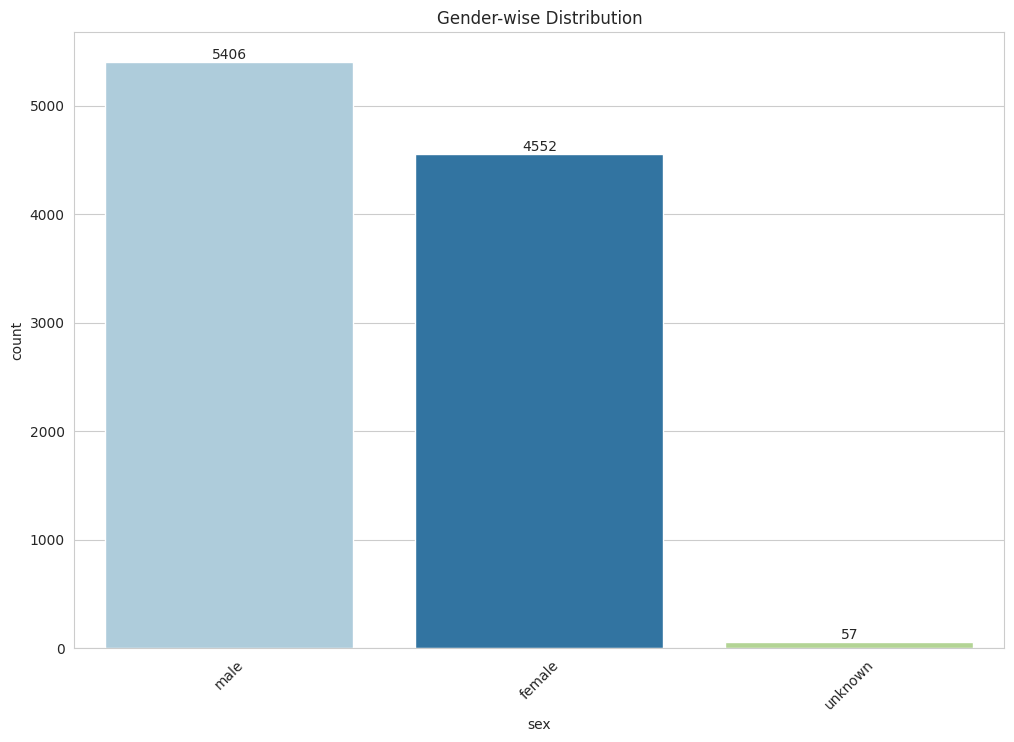

In [ ]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

Skin Cancer Types Classes

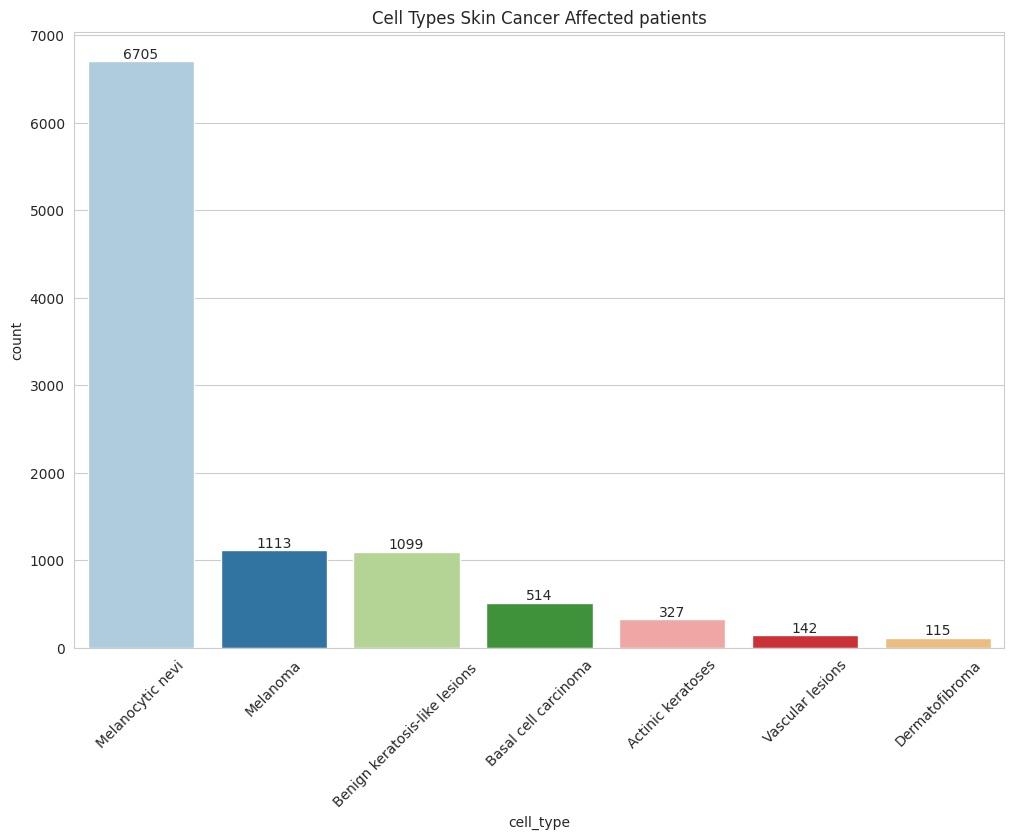

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

Skin cancer classes distribution by gender

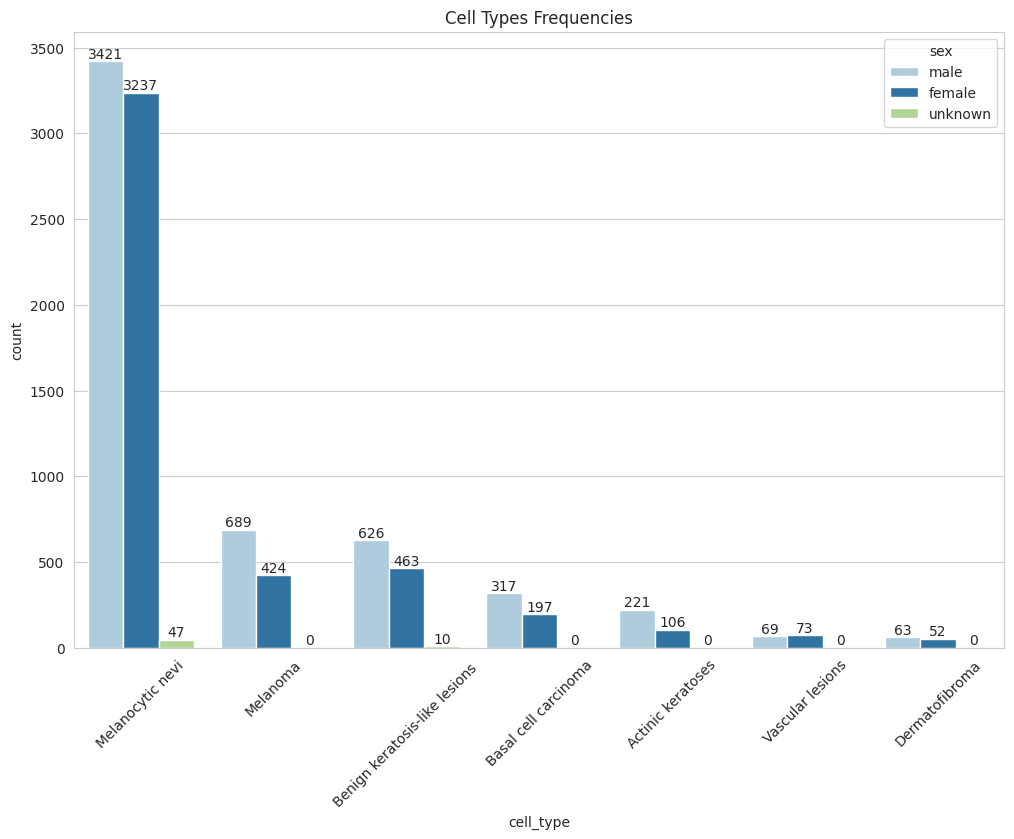

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

Cell Types Frequencies

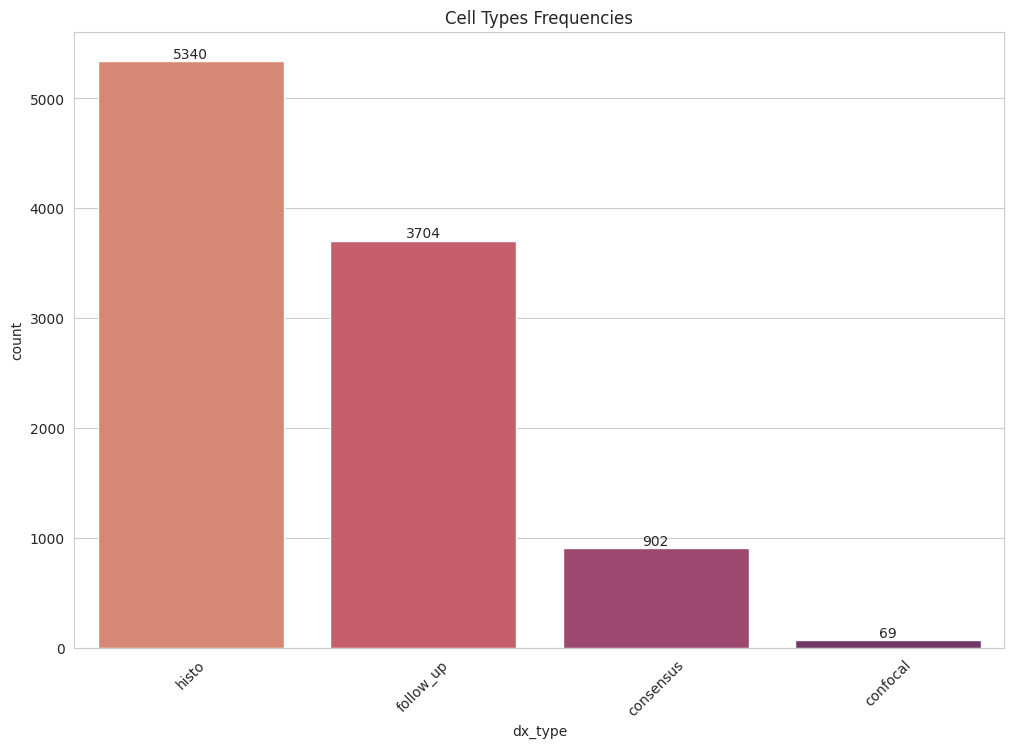

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

The distribution of Region of the body affected

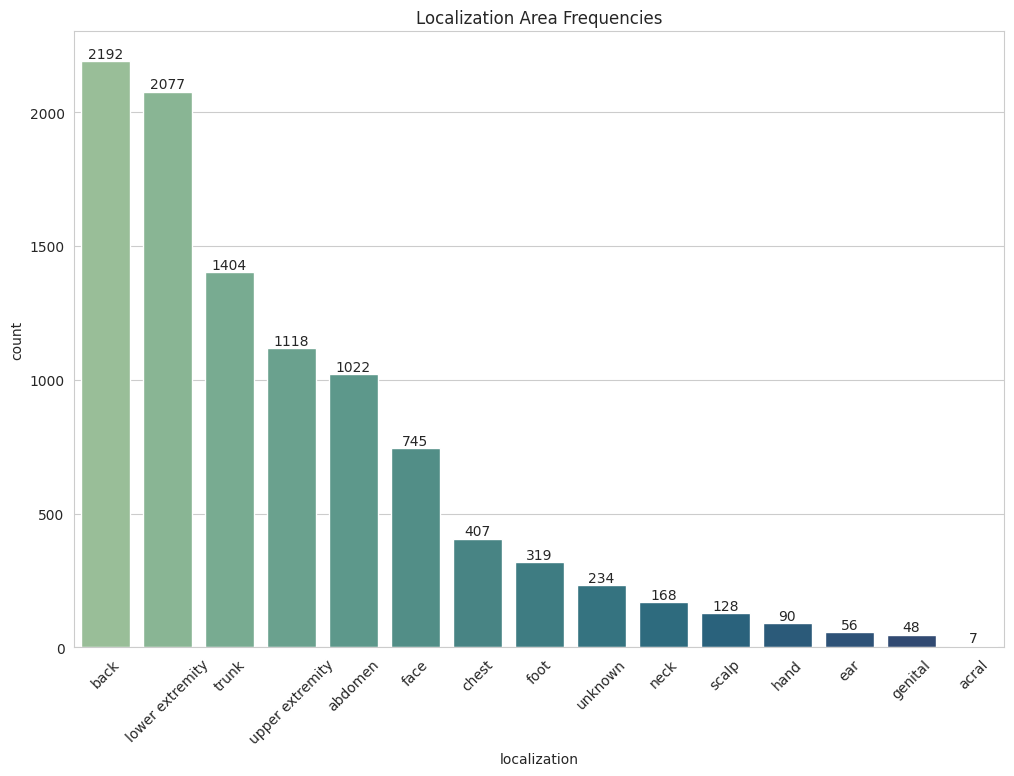

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

The distribution of the region of the body affected according to Gender

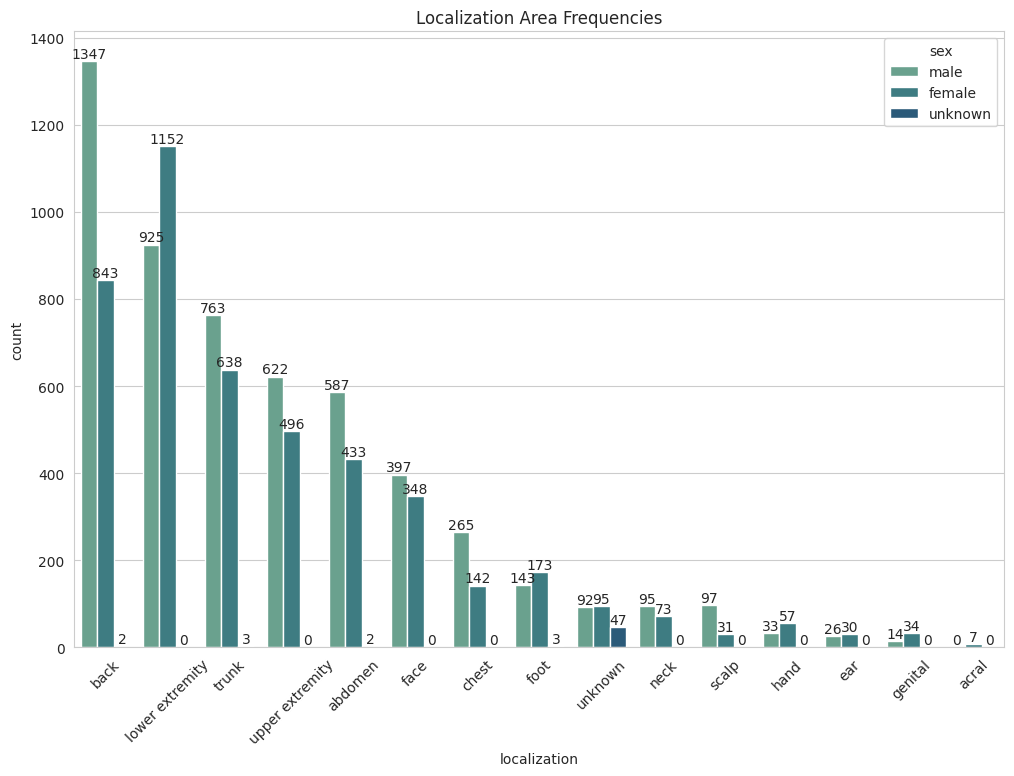

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',hue='sex', data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

Patients Age Distribution

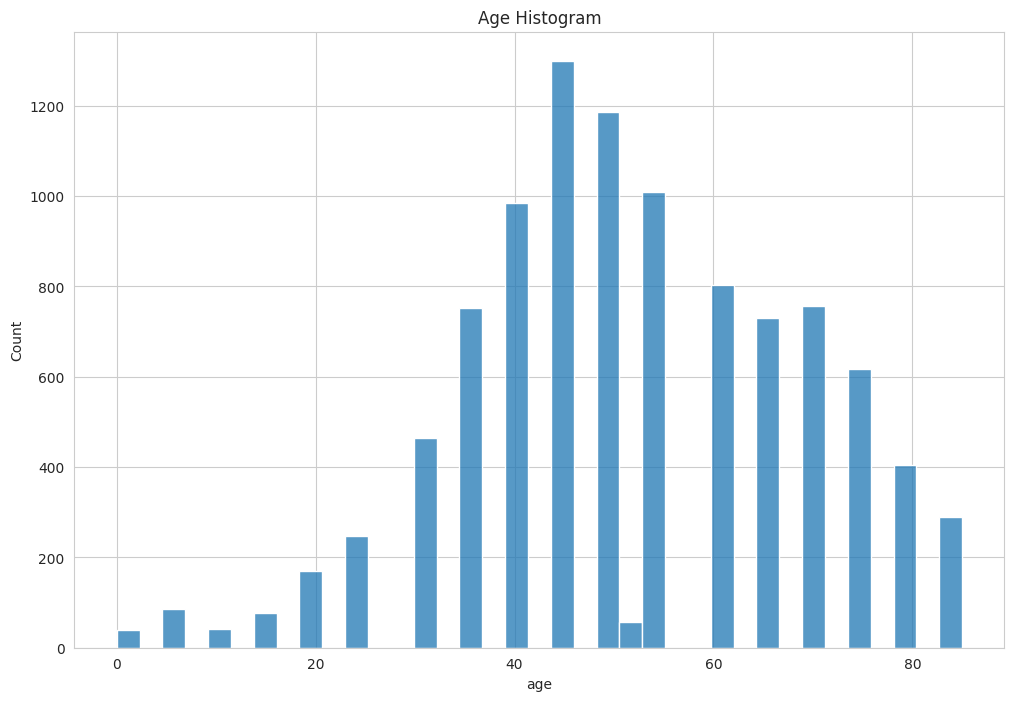

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

Patients Age - Distribution

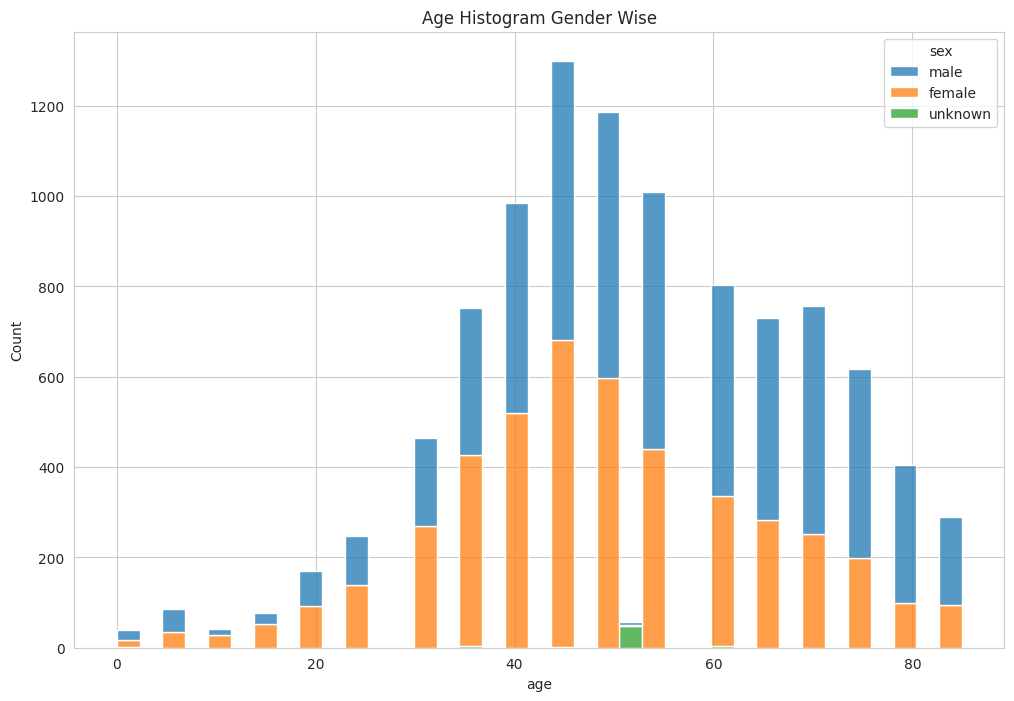

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

# Pictorial representation of Images of dataset

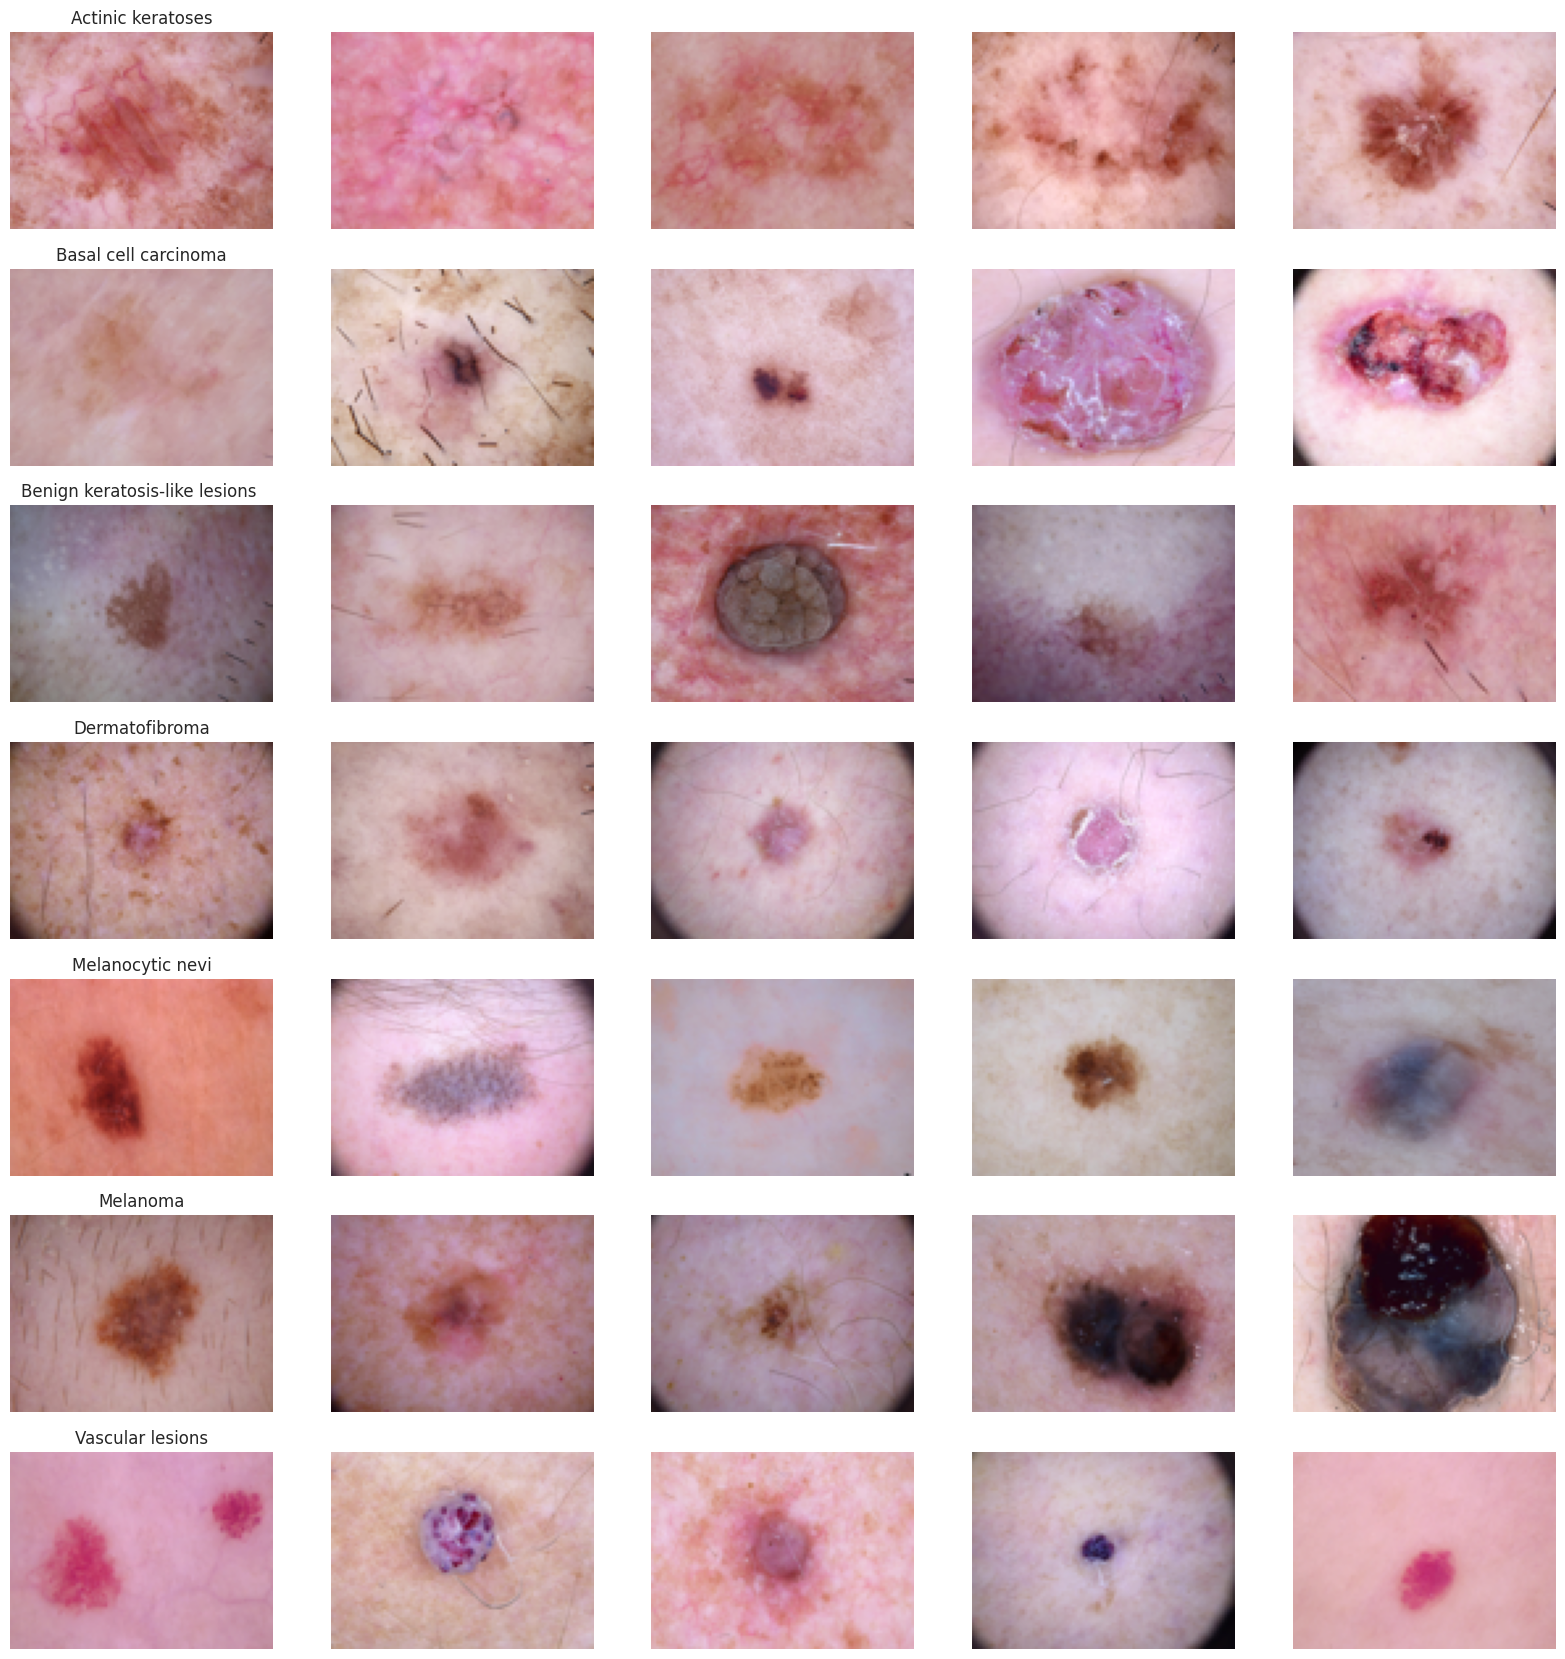

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

# Data Modeling

In [ ]:
train_path = "/content/drive//MyDrive/Skin Cancer Data sets/skin cancer 1"
test_path = "/content/drive//MyDrive/Skin Cancer Data sets/skin cancer 1"


Skin Cancer


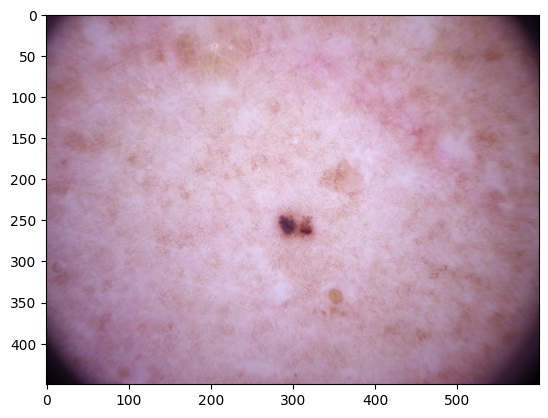

In [ ]:
# Now we will navigate into the image folders to get the skin cancer images and then visualize the first image from different image folder.

for folder in os.listdir(test_path):
  sub_path = train_path +'/'+ folder

  print(folder)
  for i in range(1):
    temp_path = os.listdir(sub_path)[1]
    temp_path = sub_path +'/'+ temp_path
    img = mpimg.imread(temp_path)
    implot = plt.imshow(img)
    plt.show()

In [ ]:
# After reading the images, we then create a function to convert the images into an array.
def imagearray(path, size):
  data = []
  for folder in os.listdir(path):
    sub_path = path + "/" + folder

    for img in os.listdir(sub_path):
      image_path = sub_path + "/" + img
      img_arr = cv2.imread(image_path)
      img_arr = cv2.resize(img_arr, size)
      data.append(img_arr)
  return data

In [ ]:
size = (224, 224)

In [ ]:
# Here, the images are converted to array and stored in the variable array
train = imagearray(train_path, size)

In [ ]:
images = np.array(train)

In [ ]:
# the images are then resized so that they maintain the same size for the training purpose

images = images/255

In [ ]:
print("image shape", images.shape)

image shape (10015, 224, 224, 3)


In [ ]:
# Define data augmentation for training images

from pandas.core.arrays import categorical

# The ImageGenerator is used for Data Augmentation, batch loading and class balancing
def data_class(images, size, class_mode):
  datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip
    fill_mode='nearest')
  classes = datagen.flow_from_directory(images,
                                        target_size = size,
                                        batch_size = 32,
                                        class_mode = categorical,
                                        shuffle = True)

  return classes

In [ ]:
# Now the feature (images) and labels (classes) are splited into train and test sets in the order of 80% and 20% respectively. Also, the split is generated randomly as specified in the code.

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1234)

In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

# Setting the Convolution Neural Network model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19

In [ ]:
# Load the pre-trained VGG19 model (excluding the top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
num_classes = 7
predictions = Dense(num_classes, activation='sigmoid')(x)  # Output layer with 7 classes for skin cancer types


# Create the final model for training
model = Model(inputs=base_model.input, outputs=predictions)


80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

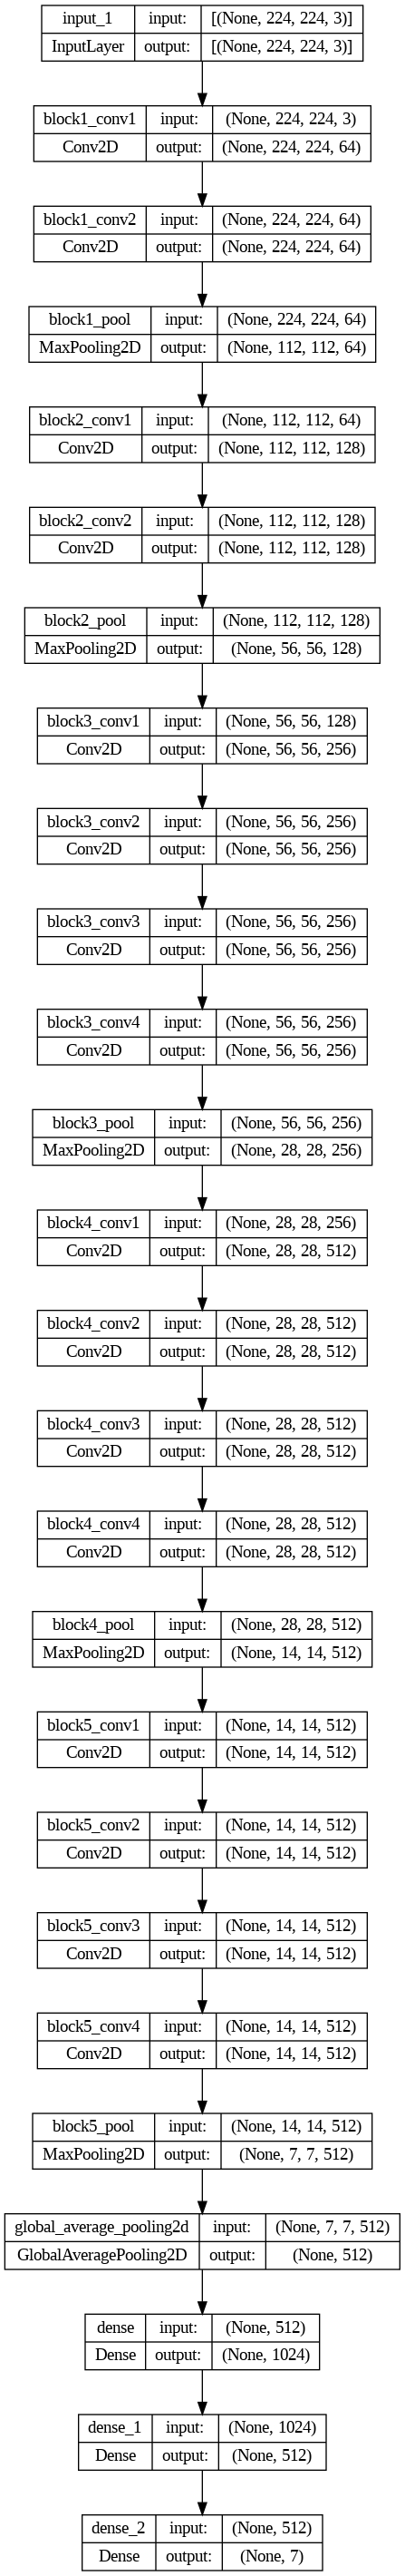

In [ ]:
plot_model(model = model, show_shapes = True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 300)

In [ ]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:

# Train the model
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 300, callbacks = [early_stop], batch_size = 32, shuffle = True)

Epoch 1/300
226/226 [==============================] - 25s 65ms/step - loss: 1.1245 - accuracy: 0.6696 - val_loss: 1.1410 - val_accuracy: 0.6633
Epoch 2/300
226/226 [==============================] - 12s 55ms/step - loss: 1.0695 - accuracy: 0.6763 - val_loss: 1.0798 - val_accuracy: 0.6671
Epoch 3/300
226/226 [==============================] - 12s 55ms/step - loss: 1.0525 - accuracy: 0.6763 - val_loss: 1.0600 - val_accuracy: 0.6721
Epoch 4/300
226/226 [==============================] - 12s 55ms/step - loss: 1.0258 - accuracy: 0.6836 - val_loss: 1.1000 - val_accuracy: 0.6671
Epoch 5/300
226/226 [==============================] - 12s 55ms/step - loss: 1.0135 - accuracy: 0.6872 - val_loss: 1.0387 - val_accuracy: 0.6733
Epoch 6/300
226/226 [==============================] - 12s 55ms/step - loss: 0.9978 - accuracy: 0.6888 - val_loss: 1.0306 - val_accuracy: 0.6858
Epoch 7/300
226/226 [==============================] - 12s 55ms/step - loss: 0.9829 - accuracy: 0.6957 - val_loss: 1.0236 - val_ac

In [ ]:
# Save the trained model for future use
model.save('/content/drive//MyDrive/Skin Cancer Data sets/detection_of_skin_cancer_model_3.tf')

In [ ]:
from keras.models import load_model

model_path = '/content/drive//MyDrive/Skin Cancer Data sets/detection_of_skin_cancer_model_3.tf'
model = load_model(model_path)


In [ ]:
# Evaluate the model on the validation set
loss_v, accuracy_v = model.evaluate(x_train, y_train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# load your test data and the predictions of the CNN model
y_pred = model.predict(x_test) # shape: (num_samples,)

# convert probabilities to class labels (0 or 1) based on a threshold of 0.5
y_pred = np.round(y_pred).astype(int)

# calculate precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# print the results
print('Precision:', precision)
print('Sensitivity:', recall)
print('F1 score:', f1_score)

63/63 [==============================] - 79s 1s/step
Precision: 0.5366949575636545
Sensitivity: 0.6550174737893161
F1 score: 0.5745548344150441


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 79s 1s/step


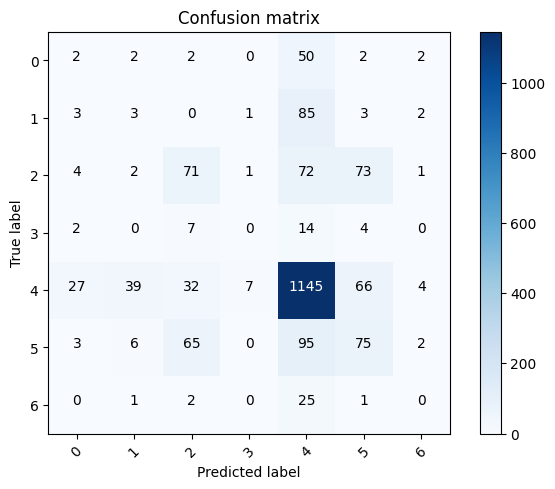

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))